In [1]:
using JSON, HTTP, CSV, DataFrames, Dates, StatsBase, PyPlot, GLMNet

prefix_match(short::String,long::String) = short == long[1:length(short)]

#Note, this only does one "layer" of expansion. For now, no more are needed, but might need updating in future.
function lineage_name_expand(lin::String; d = json_lineages)
    l = split(lin,".")[1]
    if haskey(d,l)
        if typeof(d[l]) == String && d[l] != ""
            #Non-recombinant rename
            return d[l]*lin[length(l)+1:length(lin)]
        end
    end
    #No key, or recombinant lineage
    return lin
end

function WHO_name(lin, d = WHO_dict)
    #This should be called on lineages that have been "expanded" with the above function 
    for i in length(lin):-1:1
        #Check the whole string, and then everything before a ".".
        #Note: When the string is "C.371" we don't want to match "C.37" - only if it were "C.37.1"
        if i == length(lin) || lin[i+1] == '.'
            l = lin[1:i]
            if haskey(d,l)
                return d[l]
            end
        end
    end
    return lin
end

#return true if a is equal to, or a is a parent lineage of b
function isparentlineage(a::String,b::String)
    if length(a) <= length(b)
        if (a==b) || (b[1:length(a)] == a && b[length(a)+1] == '.')
            return true
        end
    end
    return false
end

function superlineage(s)
    return join(split(s,".")[1:end-1],".")
end

superlineage (generic function with 1 method)

In [2]:
WHO_dict = Dict([
    ("B.1.1.7","Alpha"),
    ("B.1.351","Beta"),
    ("P.1","Gamma"),
    ("B.1.617.2","Delta"),
    ("C.37","Lambda"),
    ("B.1.621","Mu"),
    ("B.1.617.1","Kappa"),
    ("B.1.526","Iota"),
    ("B.1.525","Eta"),
    ("B.1.427","Epsilon"),
    ("B.1.429","Epsilon")
]);

url = "https://raw.githubusercontent.com/cov-lineages/pango-designation/master/pango_designation/alias_key.json";
imp = HTTP.get(url)
lineage_designation = String(imp.body)
json_lineages = JSON.Parser.parse(lineage_designation);

In [3]:
#Expanding the aliased WHO lineages
for k in keys(WHO_dict)
    WHO_dict[lineage_name_expand(k)] = WHO_dict[k]
end
WHO_dict

Dict{String, String} with 13 entries:
  "B.1.526"    => "Iota"
  "B.1.621"    => "Mu"
  "P.1"        => "Gamma"
  "B.1.1.28.1" => "Gamma"
  "B.1.351"    => "Beta"
  "B.1.617.2"  => "Delta"
  "B.1.1.1.37" => "Lambda"
  "B.1.525"    => "Eta"
  "B.1.1.7"    => "Alpha"
  "B.1.617.1"  => "Kappa"
  "B.1.427"    => "Epsilon"
  "C.37"       => "Lambda"
  "B.1.429"    => "Epsilon"

In [4]:
#Data import and filtering
fname = "metadata_2021_10_09.tsv"
df = CSV.read(fname, DataFrame; missingstring = ["","None","NA"], typemap=Dict(Date => String));

#Some of these only have year and month or just year recorded - we must discard them.
date_filt = length.(df."Collection date") .>= 10
println("Discarding $(sum(.!(date_filt))) for suspicious dates.")
df = df[date_filt,:]
df."Collection date" = Date.(df."Collection date","y-m-d");

pand_start = Date(Dates.Year(2019),Dates.Month(11),Dates.Day(17));

#A few filters to exclude entries with missing/outlier dates, missing locations, lineages, etc
keeps = .!ismissing.(df."Collection date")
keeps = keeps .& .!ismissing.(df."Location")
keeps = keeps .& .!ismissing.(df."Pango lineage")
keeps = keeps .& (df."Collection date" .> pand_start)
println("Discarding $(sum(.!(keeps))) for various reasons.")
df = df[keeps,:];

#Exclude recombinant lineages which cannot be collapsed - there are only about 50 seqs globally
keeps = [l[1] .!='X' for l in df."Pango lineage"] 
println("Discarding $(sum(.!(keeps))) recombinants.")
df = df[keeps,:];

Discarding 125978 for suspicious dates.
Discarding 87054 for various reasons.
Discarding 51 recombinants.


In [5]:
#Extract countries
splot = split.(df.Location, "/");
countries = String.(strip.(getindex.(splot,2),' '));
continents = String.(strip.(getindex.(splot,1),' '));
df.Countries = countries
country_list = sort(union(countries));

In [6]:
#Expanding lineage aliases, and then resolving WHO names.
df."ExpandedPango" = lineage_name_expand.(string.(df."Pango lineage"));
df."PangoOrWHO" = WHO_name.(df."ExpandedPango");

In [7]:
#Collapsing non-WHO lineages up the tree until they have 50k seqs
lineage_count_dic = countmap(df."PangoOrWHO");
lineage_collapse_thresh = 50000;

for i in 1:100 #Hacky iterate enough times.
    for l in keys(lineage_count_dic)
        c = lineage_count_dic[l]
        if lineage_count_dic[l] < lineage_collapse_thresh
            sup = superlineage(l)
            if length(sup)>0
                if haskey(lineage_count_dic,sup)
                    lineage_count_dic[sup] += c
                else
                    lineage_count_dic[sup] = c
                end
                lineage_count_dic[l] = 0
            end
        end
    end
end

all_lins = collect(keys(lineage_count_dic))

for k in keys(lineage_count_dic)
    if lineage_count_dic[k] == 0
        delete!(lineage_count_dic,k)
    end
end

reduced_lins = collect(keys(lineage_count_dic))
sort(lineage_count_dic)

OrderedCollections.OrderedDict{String, Int64} with 16 entries:
  "A"       => 15057
  "Alpha"   => 1090280
  "B"       => 18939
  "B.1"     => 387825
  "B.1.1"   => 266815
  "B.1.177" => 168047
  "B.1.2"   => 106196
  "Beta"    => 36249
  "Delta"   => 1672321
  "Epsilon" => 59665
  "Eta"     => 8015
  "Gamma"   => 89960
  "Iota"    => 40688
  "Kappa"   => 6620
  "Lambda"  => 7651
  "Mu"      => 9804

In [8]:
#This is used in a way that relies on the ancestors being later in the list than their descendents.
#Lexical sort should do the trick
POA_lineages = reverse(sort(collect(keys(lineage_count_dic))));
lineage_inds = Dict(zip(POA_lineages, 1:length(POA_lineages)));
lineage_collapse_dict = Dict([(l,POA_lineages[findfirst(isparentlineage.(POA_lineages,l))]) for l in all_lins]);

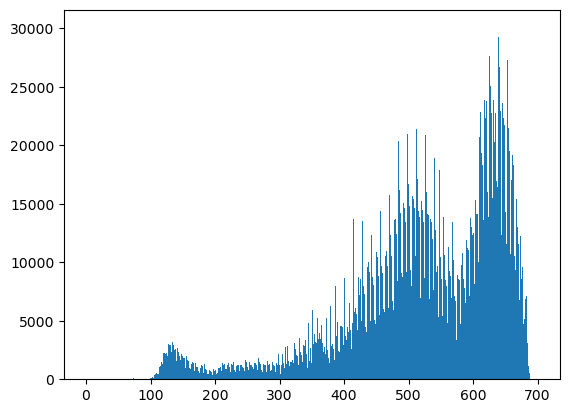

In [9]:
#Convert days to integers from the "start" of the pandemic
pand_days = Dates.value.(Date.(df."Collection date") .- pand_start);
hist(pand_days,1:700);

In [10]:
#Avoid the last ±20 days of sampling
day_cap = 668
last_day = pand_start + Day(day_cap) #2021-09-15
upper_date = Dates.value(last_day - pand_start)
keeps = (pand_days .>= 0) .& (pand_days .< upper_date)
df = df[keeps,:]
pand_days = pand_days[keeps]
df.days_since = pand_days
df = sort(df,:days_since);

In [11]:
#Picking countries to run...
loc_df = CSV.read("lat_and_lon.csv", DataFrame);
println("Countries without locations:", setdiff(country_list,loc_df.Country))
#println("Countries with locations but no seq data:", setdiff(loc_df.Country, country_list))
#Notes when fixing locations: a handful of sequences are listed as in "England". Same for "Slovak Republic" (most are "Slovakia") and "Saint Martin" (most are Sint Maarten)

Countries without locations:["England", "Saint Martin", "Slovak Republic"]


In [12]:
#RBF kernel used to locally weight samples.
#Note: if GLMNet estimates fail, try widening the bandwidth.
RBF_weighting(t,d; bw = 180) = exp(-((t-d)/bw)^2)

function fit_country(target_country, target_day; df = df, lineage_collapse_dict = lineage_collapse_dict, lineage_inds = lineage_inds)
    #target_country = "Uganda"
    min_df = df[df.Countries .== target_country,["days_since","PangoOrWHO"]]
    min_df.CollapsedLineages = [lineage_collapse_dict[l] for l in min_df."PangoOrWHO"]
    
    gdf = groupby(min_df, [:days_since, :CollapsedLineages])
    sum_df = combine(gdf, :CollapsedLineages => length => :n);
    #Adding lineage B pseudocounts to prevent overestimation of VoCs when there is no early data 
    push!(sum_df,[0,"B",500])
    wide = unstack(sum_df, [:days_since], :CollapsedLineages, :n)

    for col in names(wide)
        wide[ismissing.(wide[:,col]), col] .= 0
    end
    
    days = wide.days_since
    y_mat = Matrix(wide[:,2:end]);
    
    day_weights = RBF_weighting.(target_day,days)

    #Fit the model using GLMNet, with observations weighted around the date of interest.
    al=0.5
    path = glmnet(days[:,:], y_mat,GLMNet.Multinomial(),alpha=al, weights = day_weights,standardize = false);
    newx = collect(target_day:target_day)
    predi = GLMNet.predict(path,newx[:,:], outtype = :prob)
    
    lins = names(wide)[2:end]
    
    freqs = zeros(length(lineage_inds))
    for i in 1:length(lins)
        #Note: "predi" is the entire regularization path from GLMNet.
        #We take the last slice of this.
        freqs[lineage_inds[lins[i]]] = predi[1,i,end]
    end
    
    #Something like an effective sample size (ie. weights*counts) either side of the estimate
    #Can be used to filter countries with poor support
    weighted_totals = sum(y_mat,dims = 2) .* day_weights;
    #Note: Neff ignores the pseudocounts:
    before_neff = sum(weighted_totals[(days .> 1) .& (days .<= target_day)])
    after_neff = sum(weighted_totals[days .>= target_day])
    
    return freqs, before_neff, after_neff
end

fit_country (generic function with 1 method)

In [13]:
#Discard countries with low sampling
countries_to_estimate = String[]
for c in country_list
    if sum(df.Countries .== c) > 500
        push!(countries_to_estimate,c)
    end
end

In [14]:
#Pick the dates (in days since start) at which we want to eval the locally weighted multinomial regression
days_to_estimate = [350, 484, 623]
println("Differences: ", days_to_estimate[2:end] .- days_to_estimate[1:end-1])
pand_start .+ Day.(days_to_estimate)

Differences: [134, 139]


3-element Vector{Date}:
 2020-11-01
 2021-03-15
 2021-08-01

In [15]:
#Fit the model, and record nowcasts
output_countries = String[]
output_days = Date[]
output_freqs = Array{Float64}[];
before = Float64[]
after = Float64[]

for c in countries_to_estimate
    for d in days_to_estimate
        freqs, b, a = fit_country(c,d)
        push!(output_countries,c)
        push!(output_days,pand_start .+ Day(d))
        push!(output_freqs,freqs)
        push!(before,b)
        push!(after,a)
    end
end

In [16]:
#Get things into a data frame for export
freq_mat = hcat(output_freqs...);
estimate_df = DataFrame()
estimate_df.Country = output_countries
estimate_df.Day = output_days
estimate_df.NeffBefore = before
estimate_df.NeffAfter = after
for i in 1:length(POA_lineages)
    estimate_df[!,Symbol(POA_lineages[i])] = freq_mat[i,:]
end

In [17]:
#Collapse non-VOCs into a single "Other" column for plotting
#Note: it is important that these are first estimated separately, and then collapsed
#The (local) linearity assumption would be (more) heavily violated otherwise
nonVocs = ["B.1", "B.1.177", "B", "A", "B.1.2", "B.1.1"] #This might need to change if run on newer data!
voc_or_not_df = copy(estimate_df)
voc_or_not_df.Other = sum(Matrix(estimate_df[:,nonVocs]), dims = 2)[:];
voc_or_not_df = voc_or_not_df[:,[n for n in names(voc_or_not_df) if !(n in nonVocs)]]
CSV.write("CountryEstimates.csv",voc_or_not_df)

"CountryEstimates.csv"